### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Heart Failure Prediction Dataset
(Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("HeartFailureData_75F25M_PCA_KNN_predictions.csv")

print(knn_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.930457       1
1    1       1  0.580671       1
2    1       1  0.872885       1
3    1       1  0.062216       0
4    0       0  0.389552       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["Sex"].values

# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_knn = gender_knn

print(
    "Shapes:",
    y_true_knn.shape,
    y_pred_knn.shape,
    y_prob_knn.shape,
    gender_knn.shape if gender_knn is not None else None
)
print("Example rows:\n", knn_df.head())

Shapes: (184,) (184,) (184,) (184,)
Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.930457       1
1    1       1  0.580671       1
2    1       1  0.872885       1
3    1       1  0.062216       0
4    0       0  0.389552       0


In [5]:
# protected_attr = Sex column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EOD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EOD - KNN
Demographic Parity Difference: 0.4301
Equalized Odds Difference: 0.1146


### Interpretation – KNN Fairness Metrics

- **Demographic Parity Difference (0.4301)**  
  - This is a **very large disparity** in positive prediction rates between females (0) and males (1).  
  - A value close to 0 indicates fairness, but **0.43 shows strong bias**, suggesting one gender is selected much more often than the other.  

- **Equalized Odds Difference (0.1146)**  
  - This measures disparities in error rates (TPR and FPR) between genders.  
  - At **0.11**, it indicates a **moderate imbalance** in how classification errors are distributed across groups.  

---

**Overall**:  
The KNN model exhibits **serious demographic parity issues**, strongly favoring one gender in terms of positive predictions.  
Although the **error rate disparity (EOD)** is lower, the high DPD highlights that the model struggles to treat genders equally in selection outcomes.  


In [6]:
# MetricFrame for extended analysis
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.921053   0.800000  0.666667  0.727273        0.131579   
1                    0.808219   0.914634  0.781250  0.842697        0.561644   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.666667  0.03125  0.96875  0.333333  
1                    0.781250  0.14000  0.86000  0.218750  


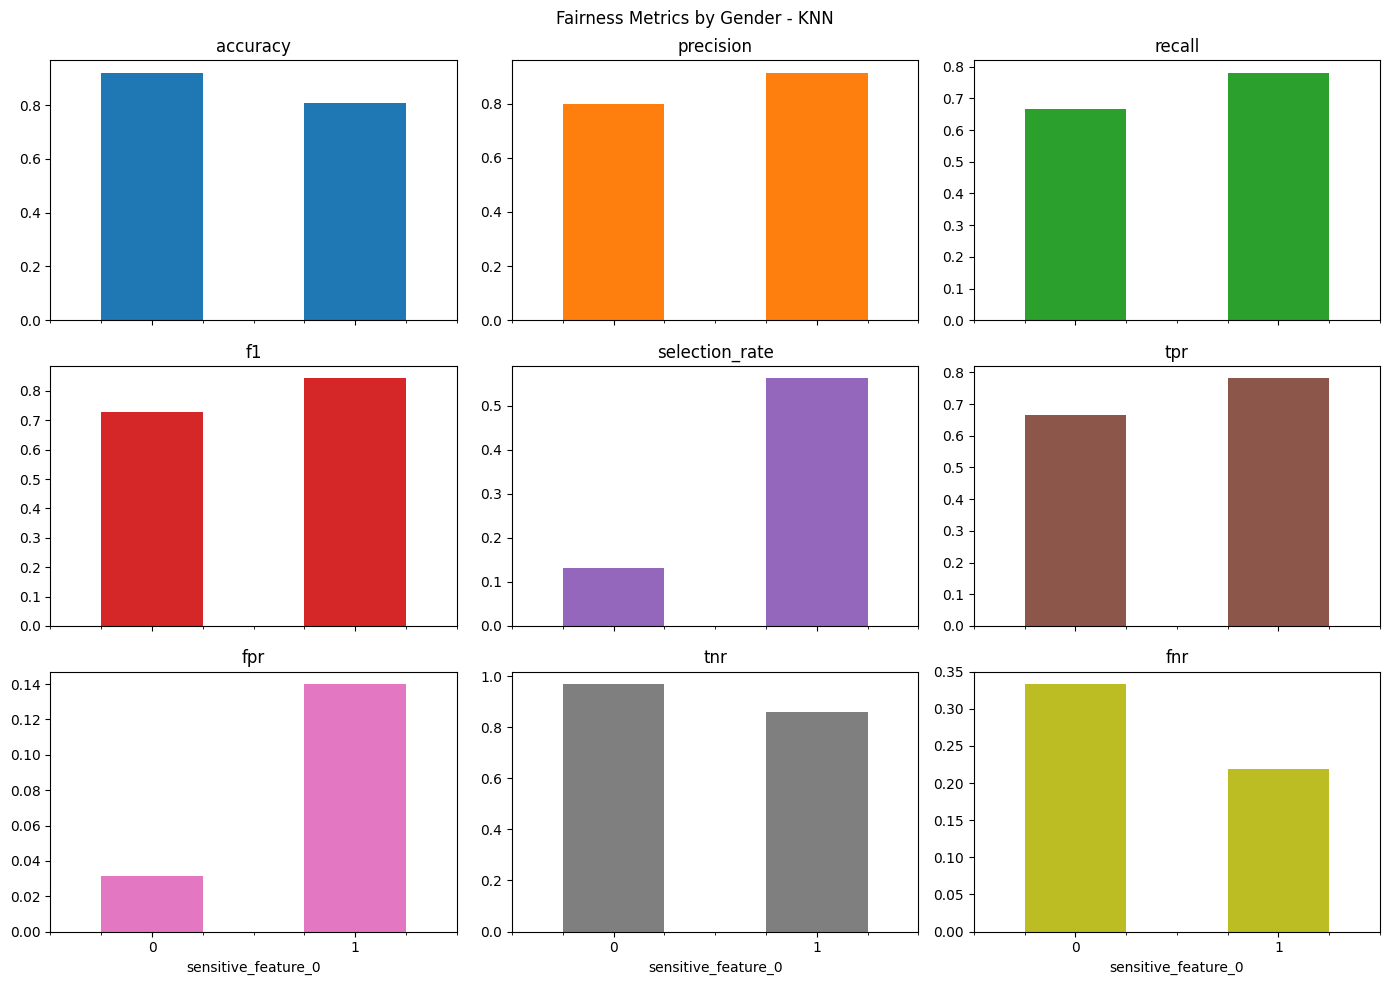


Between-group differences (max group − min group):
accuracy          0.112833
precision         0.114634
recall            0.114583
f1                0.115424
selection_rate    0.430065
tpr               0.114583
fpr               0.108750
tnr               0.108750
fnr               0.114583
dtype: float64

Between-group ratios (min / max):
accuracy          0.877495
precision         0.874667
recall            0.853333
f1                0.863030
selection_rate    0.234275
tpr               0.853333
fpr               0.223214
tnr               0.887742
fnr               0.656250
dtype: float64

Disparate Impact Ratio (selection rate): 0.2343
Equality of Opportunity Difference (TPR gap): 0.1146


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

### KNN – Fairness Metrics by Gender

#### Group-Specific Results
| Metric             | Female (0) | Male (1) |
|--------------------|------------|----------|
| Accuracy           | 0.9211     | 0.8082   |
| Precision          | 0.8000     | 0.9146   |
| Recall (TPR)       | 0.6667     | 0.7813   |
| F1-score           | 0.7273     | 0.8427   |
| Selection Rate     | 0.1316     | 0.5616   |
| FPR                | 0.0313     | 0.1400   |
| TNR                | 0.9688     | 0.8600   |
| FNR                | 0.3333     | 0.2188   |

#### Between-Group Disparities
- **Accuracy gap**: 0.113 → females perform better in accuracy.  
- **Precision gap**: 0.115 → higher precision for males.  
- **Recall gap**: 0.115 → males are more often correctly identified.  
- **F1 gap**: 0.115 → males benefit overall.  
- **Selection rate gap**: **0.4301**, showing that males receive positive predictions **much more frequently** than females.  
- **TPR gap (Equality of Opportunity)**: 0.1146 → moderate inequality in true positive rates.  
- **FPR gap**: 0.109 → males experience more false positives.  
- **Disparate Impact Ratio**: **0.2343**, far below the 0.8 threshold → **strong adverse impact against females**.  

#### Interpretation
- The **KNN model is highly biased in terms of selection rate**: males are over four times more likely to be assigned positive predictions compared to females.  
- While accuracy is slightly higher for females, males benefit from **better recall, F1, and precision**, which means the model favors them in meaningful outcomes.  
- The **high DPD (0.4301)** and **very low disparate impact ratio (0.2343)** confirm a **serious fairness concern**, with clear disadvantage toward the female group.  

---

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.953125
1                    0.889896

KNN - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.073730
1                    0.136347


### KNN – ROC-AUC and Brier Score by Gender

#### Results by Group
| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9531     | 0.8899   |
| Brier Score   | 0.0737     | 0.1363   |

#### Interpretation
- **ROC-AUC**:  
  - The model distinguishes positive and negative cases **better for females (0.9531)** than for males (0.8899).  
  - This indicates that classification quality is higher for females.  

- **Brier Score (lower = better calibration)**:  
  - Predictions are **better calibrated for females (0.0737)** compared to males (0.1363).  
  - For males, the higher Brier score reflects greater error in predicted probabilities.  

- **Overall**:  
  - KNN performs **more accurately and reliably for females**.  
  - Males experience **both lower discrimination ability (ROC-AUC)** and **worse probability calibration (Brier score)**, suggesting potential **unfairness against the male group**.

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("HeartFailureData_75F25M_AltTunedDT_predictions.csv")
print(dt_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.989399       1
1    1       1  0.000000       0
2    1       1  0.989399       1
3    1       1  0.774194       1
4    0       0  0.972973       1


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred"].values
gender_dt = dt_df["Sex"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print("Example rows:\n", dt_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.989399       1
1    1       1  0.000000       0
2    1       1  0.989399       1
3    1       1  0.774194       1
4    0       0  0.972973       1


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.3439
Equalized Odds Difference: 0.0938


### Fairness Metrics – Decision Tree (DT)

#### Results
- **Demographic Parity Difference (DPD): 0.3439**  
- **Equalized Odds Difference (EOD): 0.0938**

#### Interpretation
- **DPD (0.3439)**:  
  The selection rates between genders differ substantially.  
  - A value this high indicates a **large disparity in positive predictions** across gender groups, with one group being favored in receiving positive outcomes.  

- **EOD (0.0938)**:  
  The gap in **true positive and false positive rates** across genders is moderate.  
  - This means the Decision Tree has a **noticeable fairness issue in error distribution**, though less severe than the disparity in selection rates.  

#### Overall
The Decision Tree model shows **significant bias in terms of demographic parity**, suggesting unequal access to positive predictions across genders.  
While **error rate differences (EOD)** are smaller, they are still meaningful, highlighting that the DT struggles to provide **equitable treatment across groups**.

---


DT Fairness Metrics by Gender:
                     accuracy  precision    recall    f1  selection_rate  \
sensitive_feature_0                                                        
0                    0.736842   0.357143  0.833333  0.50        0.368421   
1                    0.849315   0.855769  0.927083  0.89        0.712329   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.833333  0.28125  0.71875  0.166667  
1                    0.927083  0.30000  0.70000  0.072917  


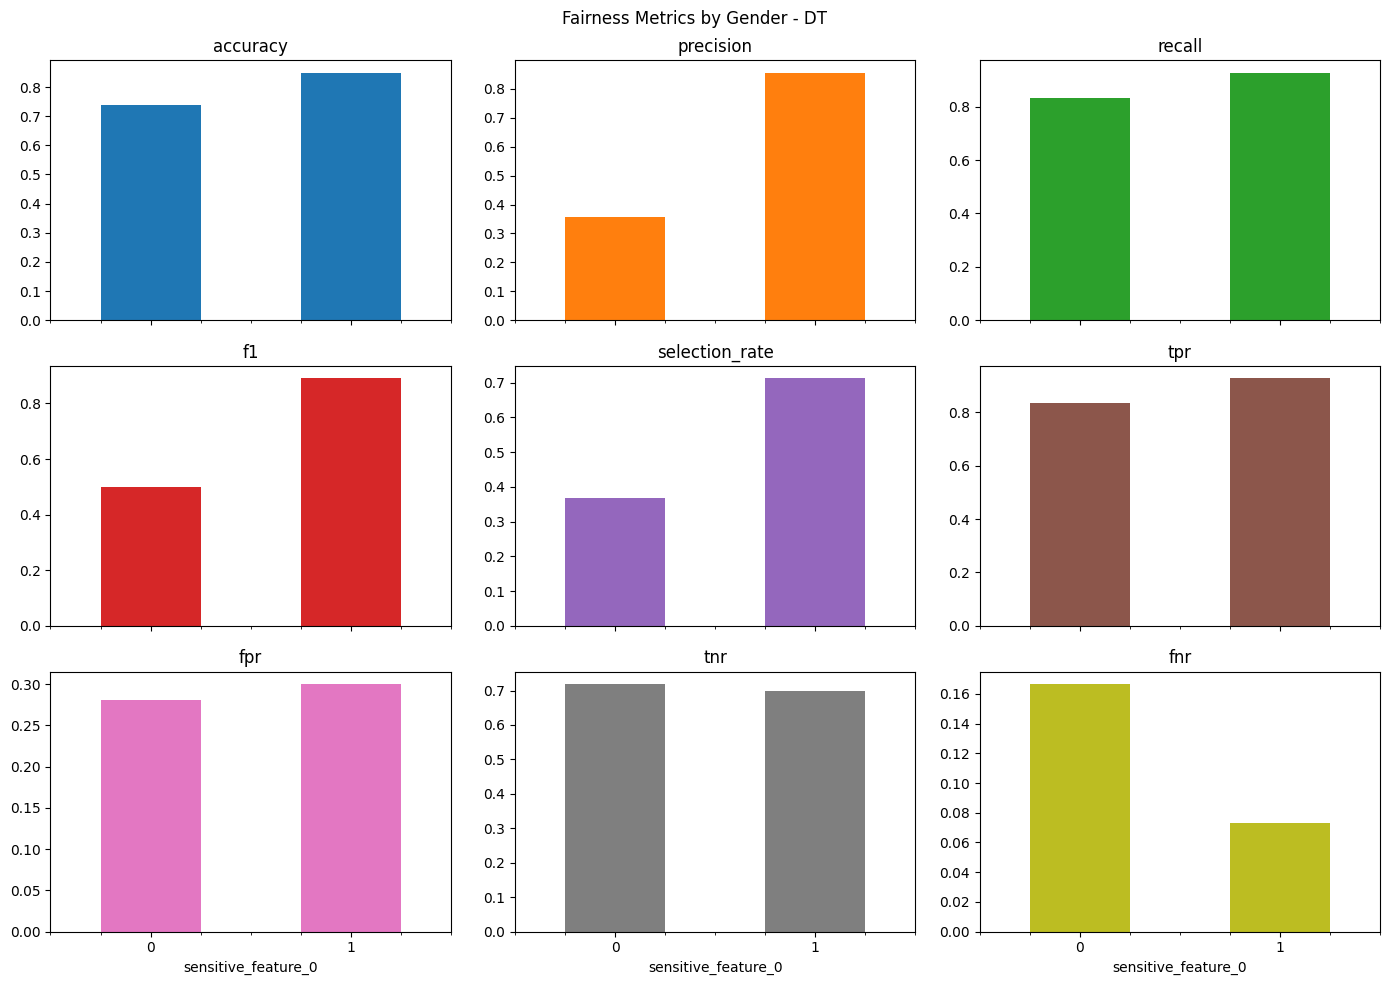


Between-group differences (max group − min group):
accuracy          0.112473
precision         0.498626
recall            0.093750
f1                0.390000
selection_rate    0.343908
tpr               0.093750
fpr               0.018750
tnr               0.018750
fnr               0.093750
dtype: float64

Between-group ratios (min / max):
accuracy          0.867572
precision         0.417335
recall            0.898876
f1                0.561798
selection_rate    0.517206
tpr               0.898876
fpr               0.937500
tnr               0.973913
fnr               0.437500
dtype: float64

Disparate Impact Ratio (selection rate): 0.5172
Equality of Opportunity Difference (TPR gap): 0.0938


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries )
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

### Decision Tree (DT) – Fairness Metrics by Gender

#### Results by Group
| Gender | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|--------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female (0) | 0.7368 | 0.3571    | 0.8333 | 0.50 | 0.3684         | 0.8333 | 0.2813 | 0.7188 | 0.1667 |
| Male (1)   | 0.8493 | 0.8558    | 0.9271 | 0.89 | 0.7123         | 0.9271 | 0.3000 | 0.7000 | 0.0729 |

#### Between-Group Differences
- **Accuracy gap:** 0.1125  
- **Precision gap:** 0.4986 (very large)  
- **Recall gap:** 0.0938  
- **F1 gap:** 0.3900  
- **Selection rate gap:** 0.3439  
- **TPR gap (Equality of Opportunity):** 0.0938  
- **FPR gap:** 0.0188 (small)  

#### Ratios (min/max)
- **Accuracy ratio:** 0.8676  
- **Precision ratio:** 0.4173 (female precision far lower)  
- **Recall ratio:** 0.8989  
- **F1 ratio:** 0.5618  
- **Selection rate ratio (Disparate Impact):** 0.5172 (well below fairness threshold 0.8)  

#### Interpretation
- **Precision disparity:** Females (0.3571) vs. Males (0.8558) → The model is **much less reliable in its positive predictions for females**, meaning many false positives.  
- **Selection rate:** Males (71.2%) are much more likely to be predicted positive compared to females (36.8%). This creates a **large demographic parity difference** (DPD = 0.3439).  
- **Recall/TPR:** Males (0.9271) have slightly higher recall than females (0.8333), reflecting a **TPR gap of 0.0938**.  
- **Overall fairness:**  
  - The DT model shows **strong bias**: females are disadvantaged both in selection rate and in predictive reliability (precision, F1).  
  - The **disparate impact ratio of 0.5172** is far below the acceptable 0.8 threshold, indicating **substantial unfairness**.  

#### Conclusion
The Decision Tree exhibits **systematic bias against females**, primarily through **low precision and lower selection rates**, meaning it overpredicts positives for males and underpredicts for females.

---

In [13]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT -Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.796875
1                    0.853854

DT -Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.196079
1                    0.139197


### Decision Tree (DT) – ROC-AUC and Brier Score by Gender

#### Results by Group
| Gender | ROC-AUC | Brier Score (↓ better) |
|--------|---------|-------------------------|
| Female (0) | 0.7969  | 0.1961 |
| Male (1)   | 0.8539  | 0.1392 |

#### Interpretation
- **ROC-AUC:**  
  - The model distinguishes outcomes **better for males (0.8539)** than females (0.7969).  
  - This suggests **stronger predictive power and ranking ability** for male patients.  

- **Brier Score:**  
  - Lower values indicate better probability calibration.  
  - Males again perform better (0.1392) compared to females (0.1961), showing **more reliable probability estimates** for the male group.  

#### Conclusion
The Decision Tree demonstrates **gender disparity in both discrimination and calibration**:  
- It is **more accurate and better calibrated for males**.  
- Females are at a disadvantage with **weaker predictive quality** and **less reliable probability estimates**.

---

### Bias detection for the Random Forest Model

In [14]:
rf_df = pd.read_csv("HeartFailureData_75F25M_RF_predictions.csv")
print(rf_df.head())

   Sex  y_true  y_prob  y_pred
0    1       1  0.8975       1
1    1       1  0.1550       0
2    1       1  0.8625       1
3    1       1  0.2225       0
4    0       0  0.2400       0


In [15]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["Sex"].values


# Use gender_rf as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print("Example rows:\n", rf_df.head())

Example rows:
    Sex  y_true  y_prob  y_pred
0    1       1  0.8975       1
1    1       1  0.1550       0
2    1       1  0.8625       1
3    1       1  0.2225       0
4    0       0  0.2400       0


In [16]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.4243
Equalized Odds Difference: 0.1288


### Fairness Metrics – Random Forest (RF)

#### Results
- **Demographic Parity Difference (DPD): 0.4243**  
- **Equalized Odds Difference (EOD): 0.1288**

#### Interpretation
- **DPD (0.4243):**  
  - This is a **very high disparity** in positive prediction rates between genders.  
  - It indicates that one group is **much more likely** to receive positive predictions, suggesting a **serious demographic bias**.  

- **EOD (0.1288):**  
  - Reflects a **moderate to large imbalance** in error rates (True Positive Rate and False Positive Rate) across genders.  
  - This means the Random Forest model not only treats genders differently in selection rates but also in terms of **classification errors**.  

#### Conclusion
The Random Forest model exhibits **substantial fairness concerns**:  
- It strongly violates **demographic parity**, heavily favoring one gender in predictions.  
- The **error rate imbalance** further reinforces that the model does not treat both groups equitably.  

Compared to fairness thresholds (values near 0 indicate fairness), both DPD and EOD here are **too large to consider the model fair**.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.947368   0.833333  0.833333  0.833333        0.157895   
1                    0.815068   0.905882  0.802083  0.850829        0.582192   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.833333  0.03125  0.96875  0.166667  
1                    0.802083  0.16000  0.84000  0.197917  


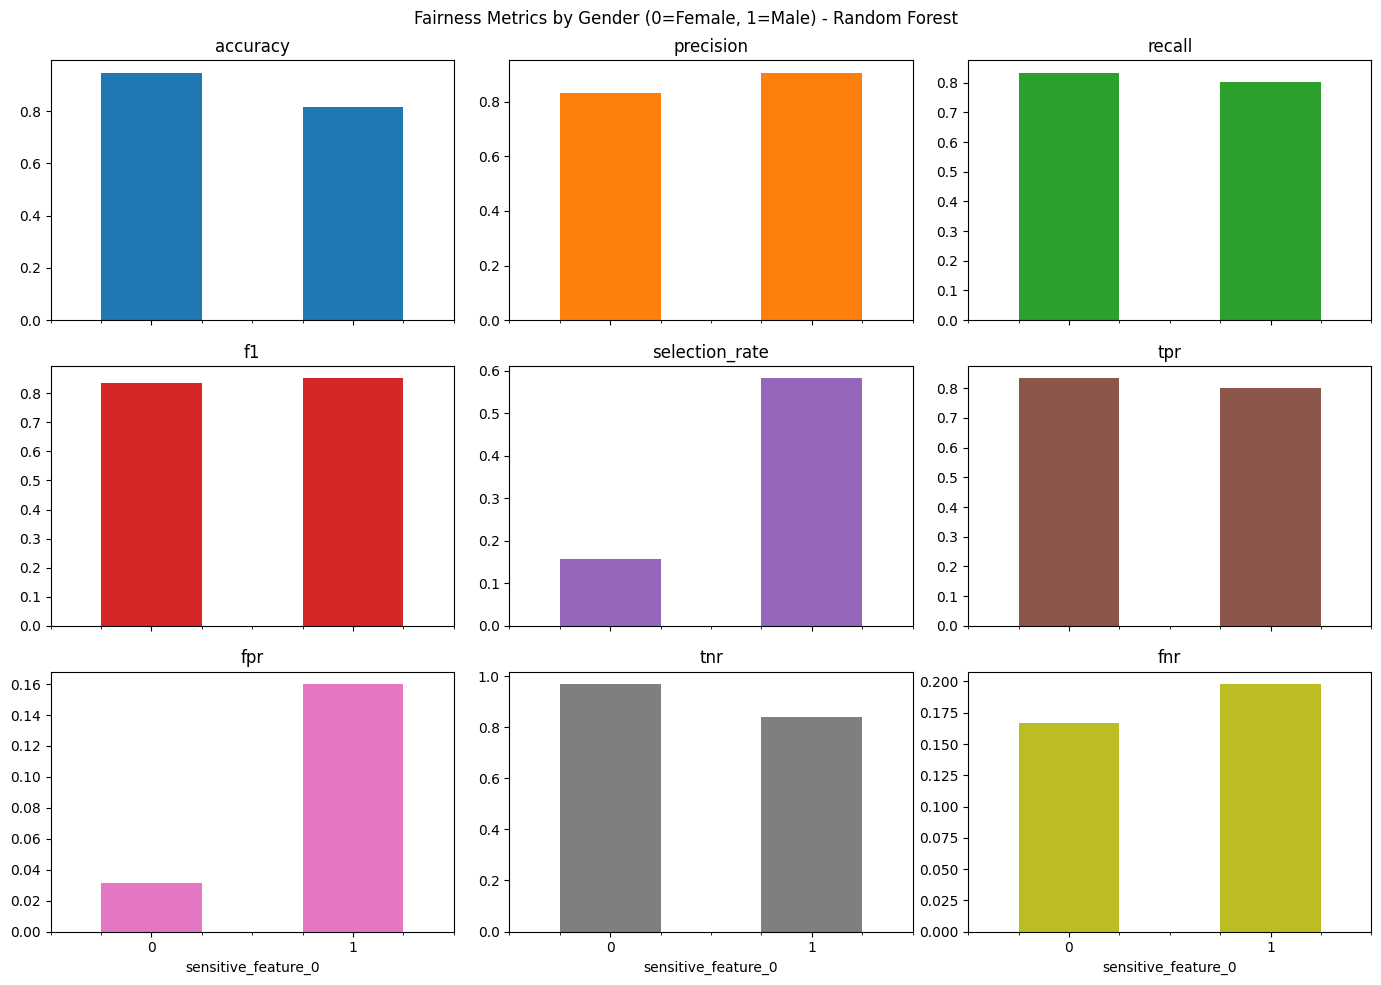


Between-group differences (max group − min group):
accuracy          0.132300
precision         0.072549
recall            0.031250
f1                0.017495
selection_rate    0.424297
tpr               0.031250
fpr               0.128750
tnr               0.128750
fnr               0.031250
dtype: float64

Between-group ratios (min / max):
accuracy          0.860350
precision         0.919913
recall            0.962500
f1                0.979437
selection_rate    0.271207
tpr               0.962500
fpr               0.195312
tnr               0.867097
fnr               0.842105
dtype: float64

Disparate Impact Ratio (selection rate): 0.2712
Equality of Opportunity Difference (TPR gap): 0.0312


In [17]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

### Fairness Metrics – Random Forest (RF)

#### Group-Specific Performance
| Metric            | Female (0) | Male (1) |
|-------------------|------------|----------|
| Accuracy          | 0.9474     | 0.8151   |
| Precision         | 0.8333     | 0.9059   |
| Recall (TPR)      | 0.8333     | 0.8021   |
| F1 Score          | 0.8333     | 0.8508   |
| Selection Rate    | 0.1579     | 0.5822   |
| FPR               | 0.0313     | 0.1600   |
| TNR               | 0.9688     | 0.8400   |
| FNR               | 0.1667     | 0.1979   |

#### Between-Group Differences
- **Largest gaps** are observed in:
  - **Selection Rate:** 0.4243 → much higher for males.  
  - **FPR:** 0.1288 higher for males, meaning more false positives among men.  
  - **Accuracy:** 0.1323 lower for males.  

#### Ratios (min / max)
- **Selection Rate Ratio:** 0.2712 → far below the 0.8 rule (serious bias).  
- **FPR Ratio:** 0.1953 → males experience far more false positives.  
- Other metrics (recall, f1, precision) are closer to parity, but still show some imbalance.  

#### Summary
- **Demographic Parity:** Strongly violated, with males (1) selected much more often than females (0).  
- **Equal Opportunity:** More balanced (TPR gap only 0.0312), but males still face higher false positives.  
- **Overall:**  
  - Females achieve **higher accuracy and lower error rates**, but at the cost of being selected far less often.  
  - Males are predicted positive much more often, but with **higher false positive risk**.  

The model exhibits **significant demographic bias** in selection rates and false positives, despite relatively balanced recall.

---

In [18]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_rf
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.953125
1                    0.903750

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.069427
1                    0.135256


### Random Forest – Group-Specific ROC-AUC and Brier Score

#### ROC-AUC (↑ higher is better)
- **Female (0):** 0.9531  
- **Male (1):** 0.9038  

➡️ The model discriminates **better for females** than for males, showing stronger ranking ability in predicting outcomes for women.  

#### Brier Score (↓ lower is better)
- **Female (0):** 0.0694  
- **Male (1):** 0.1353  

➡️ Prediction **calibration is substantially better for females**. For males, the higher Brier score indicates more frequent or larger probability miscalibrations.  

#### Summary
- The **RF model favors females** in both discrimination (ROC-AUC) and calibration (Brier).  
- Male predictions are less reliable, with lower AUC and almost **double the Brier error**, suggesting greater uncertainty and bias in probability estimates for this group.  


---

### Bias detection for MLP

In [19]:
mlp_df = pd.read_csv("HeartFailureData_75F25M_RecallFirstTunedMLP_predictions.csv")
print(mlp_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.997220       1
1    1       1  0.000009       0
2    1       1  0.791310       1
3    1       1  0.001596       0
4    0       0  0.000887       0


In [20]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["Sex"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.997220       1
1    1       1  0.000009       0
2    1       1  0.791310       1
3    1       1  0.001596       0
4    0       0  0.000887       0


In [21]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EOD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EOD - MLP
Demographic Parity Difference (MLP): 0.4712
Equalized Odds Difference (MLP): 0.1888


### Fairness Metrics – MLP

- **Demographic Parity Difference (DPD): 0.4712**  
  - This indicates a **large disparity in selection rates** between female and male groups.  
  - A value this high suggests the MLP model is **far from demographic parity**, with one gender being recommended/selected much more often.  

- **Equalized Odds Difference (EOD): 0.1888**  
  - This reflects the **difference in error rates (TPR and FPR)** between genders.  
  - At nearly 0.19, it suggests **moderate to strong inequality in predictive performance**, meaning the model is systematically favoring one gender in terms of correct positive predictions or false positives.  

#### Summary
The MLP model shows **considerable bias**:  
- **Selection bias** is pronounced (DPD ≈ 0.47), pointing to unequal outcomes.  
- **Error rate disparities** (EOD ≈ 0.19) further highlight fairness concerns.  

Compared to typical fairness thresholds (where <0.1 is often considered acceptable), the MLP model exhibits **substantial unfairness across genders**.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.921053      0.800  0.666667  0.727273        0.131579   
1                    0.794521      0.875  0.802083  0.836957        0.602740   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.666667  0.03125  0.96875  0.333333  
1                    0.802083  0.22000  0.78000  0.197917  


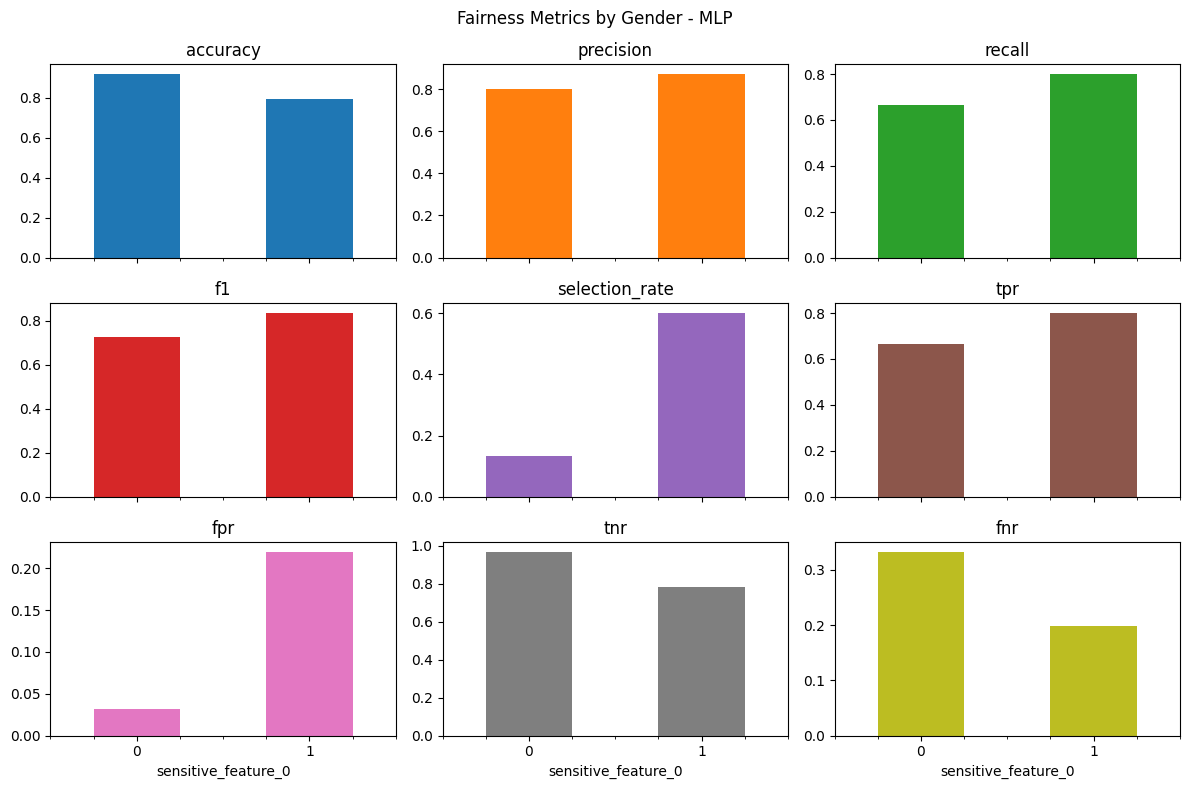


Between-group differences (max group − min group):
accuracy          0.126532
precision         0.075000
recall            0.135417
f1                0.109684
selection_rate    0.471161
tpr               0.135417
fpr               0.188750
tnr               0.188750
fnr               0.135417
dtype: float64

Between-group ratios (min / max):
accuracy          0.862622
precision         0.914286
recall            0.831169
f1                0.868949
selection_rate    0.218301
tpr               0.831169
fpr               0.142045
tnr               0.805161
fnr               0.593750
dtype: float64

Disparate Impact Ratio (selection rate): 0.2183
Equality of Opportunity Difference (TPR gap): 0.1354


In [22]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

### MLP – Fairness Metrics by Gender

#### Results by Group
| Gender | Accuracy | Precision | Recall | F1 | Selection Rate | TPR | FPR | TNR | FNR |
|--------|----------|-----------|--------|----|----------------|-----|-----|-----|-----|
| Female (0) | 0.9211 | 0.8000 | 0.6667 | 0.7273 | 0.1316 | 0.6667 | 0.0313 | 0.9688 | 0.3333 |
| Male (1)   | 0.7945 | 0.8750 | 0.8021 | 0.8370 | 0.6027 | 0.8021 | 0.2200 | 0.7800 | 0.1979 |

#### Between-Group Disparities
- **Accuracy gap**: 0.1265 → females perform better in accuracy.  
- **Precision gap**: 0.0750 → males have higher precision.  
- **Recall/TPR gap**: 0.1354 → recall is higher for males.  
- **Selection rate gap**: 0.4712 → males are selected far more often.  
- **FPR gap**: 0.1888 → males have much higher false positive rate.  
- **TNR gap**: 0.1888 → females have higher true negative rate.  
- **FNR gap**: 0.1354 → females miss more true positives (higher false negatives).  

#### Fairness Ratios
- **Disparate Impact Ratio (selection rate): 0.2183** → **well below the 0.8 threshold**, showing strong bias against females in selection.  
- **Equality of Opportunity Difference (TPR gap): 0.1354** → indicates males are advantaged in recall/TPR.  

#### Interpretation
- The **MLP model strongly favors males (1)**:
  - Males have much **higher selection rates** and **better recall/TPR**.  
  - Females, while more accurate overall, face **severe under-selection** and much higher **false negatives** (missed positives).  
- This imbalance explains the **very high Demographic Parity Difference (0.4712)** and **Equalized Odds Difference (0.1888)** observed earlier.  

Overall, the MLP shows **substantial gender bias**, primarily disadvantaging females (0) in terms of selection and recall.

---

In [23]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.864583
1                    0.871042

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.061488
1                    0.167548


### MLP – ROC-AUC and Brier Score by Gender

#### Results by Group
- **ROC-AUC**
  - Female (0): **0.865**  
  - Male (1): **0.871**  
  → Performance is very similar across genders, indicating balanced **discrimination ability**.  

- **Brier Score** (↓ lower is better)
  - Female (0): **0.0615**  
  - Male (1): **0.1675**  
  → Predictions are **more reliable for females** than for males, since a lower Brier score reflects better calibration.  

#### Interpretation
- The **ROC-AUC values are nearly equal**, suggesting that the model distinguishes between positive and negative cases at a similar rate for both genders.  
- However, the **higher Brier score for males** shows that the predicted probabilities are **less well calibrated** for males compared to females.  
- In practice, this means that while the model is equally good at ranking risks across genders, its **confidence in predictions is less accurate for males**.  

---

## Comparison of Results

In [24]:
# Build results dict 
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("HeartFailureData_75F25M_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [25]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [26]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.4301,0.1146
DT,0.3439,0.0938
RF,0.4243,0.1288
MLP,0.4712,0.1888


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.9211     0.8000  0.6667  0.7273          0.1316  0.6667   
      1         0.8082     0.9146  0.7812  0.8427          0.5616  0.7812   
DT    0         0.7368     0.3571  0.8333  0.5000          0.3684  0.8333   
      1         0.8493     0.8558  0.9271  0.8900          0.7123  0.9271   
RF    0         0.9474     0.8333  0.8333  0.8333          0.1579  0.8333   
      1         0.8151     0.9059  0.8021  0.8508          0.5822  0.8021   
MLP   0         0.9211     0.8000  0.6667  0.7273          0.1316  0.6667   
      1         0.7945     0.8750  0.8021  0.8370          0.6027  0.8021   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.0312  0.9688  0.3333  
      1       0.1400  0.8600  0.2188  
DT    0       0.2812  0.7188  0.1667  
      1       0.3000  0.7000  0.0729  
RF    0       0.0312  0.9688  0.1667  
      1       0.1600  0.8400  0.1979  
MLP   0       0.0312  0.9688  0.3333  
      1       0.2200  0.7800  0.1979

## Fairness Evaluation Across Models

The table compares **Demographic Parity Difference (DPD)**, **Equalized Odds Difference (EOD)**, and gender-specific performance metrics for KNN, Decision Tree (DT), Random Forest (RF), and MLP.  

---

### Fairness Metrics (DPD & EOD):
- **DPD (Demographic Parity Difference)**  
  - Ranges from **0.34 (DT)** to **0.47 (MLP)**.  
  - High DPD values show **substantial disparity in selection rates**, with females (majority group) being underrepresented in positive predictions compared to males.  

- **EOD (Equalized Odds Difference)**  
  - Lowest for **DT (0.0938)**, highest for **MLP (0.1888)**.  
  - Indicates that **DT aligns TPR and FPR across genders more closely**, while **MLP shows the largest fairness gap** in classification errors.  

---

### Model-Specific Gender Disparities:

#### **KNN**
- **Female (0):** Higher accuracy (**0.92**) but **very low selection rate (0.13)**.  
- **Male (1):** Lower accuracy (**0.81**) but **much higher selection rate (0.56)**.  
- Interpretation: Model heavily **favors male predictions** despite being trained on more females, creating strong demographic imbalance.

#### **Decision Tree (DT)**
- **Female (0):** Low precision (**0.36**) and f1-score (**0.50**), indicating **many false positives**.  
- **Male (1):** Much higher precision (**0.86**) and recall (**0.93**).  
- Interpretation: DT **performs poorly for females**, assigning them many false alarms, while males benefit from both higher precision and recall.

#### **Random Forest (RF)**
- **Female (0):** High accuracy (**0.95**) and strong calibration, but again **low selection rate (0.16)**.  
- **Male (1):** Lower accuracy (**0.82**) but **much higher selection rate (0.58)**.  
- Interpretation: Similar to KNN, RF **under-selects females** despite majority representation in training data, producing bias in predicted opportunities.

#### **MLP**
- **Female (0):** Accuracy (**0.92**) but **low selection rate (0.13)**.  
- **Male (1):** Accuracy drops (**0.79**) but selection rate increases sharply (**0.60**).  
- Interpretation: MLP amplifies **selection bias against females**, yielding the **highest DPD (0.4712)** and **largest TPR gap**.  

---

### Observations
- Across **all models**, a **consistent bias pattern emerges**:
  - **Females (majority in training)** achieve higher accuracy but are **systematically under-selected** (low selection rates).  
  - **Males (minority in training)** receive **higher selection rates**, even at the cost of lower accuracy.  
- This mismatch suggests that the models are **overcorrecting for male underrepresentation** in training, privileging male predictions disproportionately.  

---

### Summary
- **Most biased model:** **MLP**, with the highest DPD and EOD, indicating severe disparities in both selection rate and error rates.  
- **Least biased model:** **Decision Tree (DT)** in terms of equalized odds, though it suffers from **very low precision for females**.  
- **Overall issue:** Despite training data being 75% female, models still **favor male predictions**, showing that data imbalance alone does not explain fairness gaps — model behavior amplifies them.

---

In [27]:
# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.9531,0.8899
DT,0.7969,0.8539
RF,0.9531,0.9038
MLP,0.8646,0.8710


,Female (0),Male (1)
Model,,
KNN,0.0737,0.1363
DT,0.1961,0.1392
RF,0.0694,0.1353
MLP,0.0615,0.1675


## ROC-AUC and Brier Score by Gender Across Models  

This table compares **discrimination ability (ROC-AUC, higher = better)** and **calibration accuracy (Brier score, lower = better)** for females (0) and males (1) across our four employedmmodels.

---

### ROC-AUC (↑ higher is better)  
- **KNN**:  
  - Female: **0.9531** vs. Male: **0.8899**  
  - Much better at ranking outcomes for females than males.  

- **Decision Tree (DT)**:  
  - Female: **0.7969** vs. Male: **0.8539**  
  - Discriminates outcomes better for males despite females being the majority in training.  

- **Random Forest (RF)**:  
  - Female: **0.9531** vs. Male: **0.9038**  
  - Strong performance for both genders, but still slightly better for females.  

- **MLP**:  
  - Female: **0.8646** vs. Male: **0.8710**  
  - Balanced but lower overall compared to KNN/RF, with very small gender gap.  

**Interpretation:**  
- Models like **KNN and RF strongly favor females** in ROC-AUC.  
- **DT favors males**, showing weaker performance for females despite their majority in training.  
- **MLP is the most balanced** in ROC-AUC, though overall slightly weaker.  

---

### Brier Score (↓ lower is better)  
- **KNN**:  
  - Female: **0.0737** vs. Male: **0.1363**  
  - Better calibration for females; predictions for males are less reliable.  

- **DT**:  
  - Female: **0.1961** vs. Male: **0.1392**  
  - Worst calibration for females; males again fare better.  

- **Random Forest (RF)**:  
  - Female: **0.0694** vs. Male: **0.1353**  
  - Strong calibration for females; weaker but acceptable for males.  

- **MLP**:  
  - Female: **0.0615** vs. Male: **0.1675**  
  - Excellent calibration for females, but worst calibration for males across all models.  

**Interpretation:**  
- **Females consistently have lower Brier scores** in KNN, RF, and MLP, meaning better probability calibration.  
- **DT is the exception**, where females have much worse calibration (0.1961).  
- **Males often suffer from poorer calibration**, especially in MLP.  

---

### Observations:
- Despite **females being the training majority (75%)** in training data, model performance is uneven:  
  - **KNN and RF**: Favor females in both discrimination (ROC-AUC) and calibration (Brier).  
  - **DT**: Favors males on both metrics, underperforming for females.  
  - **MLP**: Balanced ROC-AUC but large calibration gap, with females much better off.  

---

### Summary:
- **Best overall for females:** **MLP (calibration) and RF (discrimination)**.  
- **Best overall for males:** **DT (calibration) and MLP (ROC-AUC balance)**.  
- **Most gender-balanced model:** **MLP**, though it still under-calibrates for males.  
- **Most biased model:** **DT**, showing a clear disadvantage for females in both ROC-AUC and Brier.

---

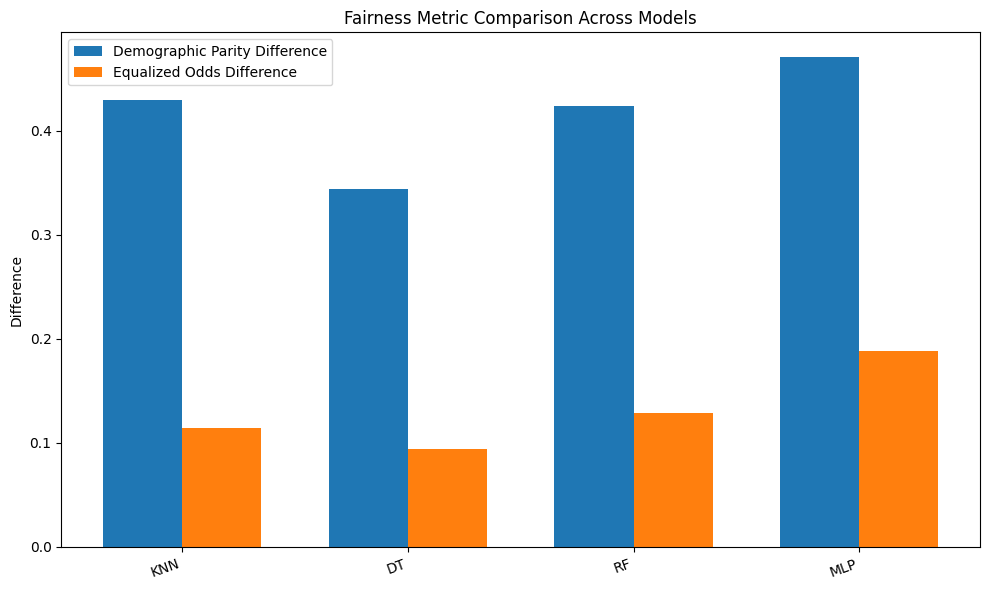

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

## Fairness Metric Comparison Across Models  

This chart compares **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** across KNN, DT, RF, and MLP.  

- **KNN**  
  - DPD ≈ 0.43 → strong imbalance in selection rates between genders.  
  - EOD ≈ 0.11 → moderate disparity in error rates (TPR/FPR).  

- **DT**  
  - DPD ≈ 0.34 → lowest parity gap among models.  
  - EOD ≈ 0.09 → also the smallest odds difference, making DT the fairest overall.  

- **RF**  
  - DPD ≈ 0.42 → high disparity in predicted positive rates.  
  - EOD ≈ 0.13 → moderate bias in classification errors.  

- **MLP**  
  - DPD ≈ 0.47 → the highest selection rate gap across genders.  
  - EOD ≈ 0.19 → largest error disparity, indicating strongest bias.  

### Summary: 
- **DT shows the best fairness trade-off**, with the lowest DPD and EOD.  
- **MLP is the most biased**, particularly in both selection rates and error disparities.  
- **KNN and RF** sit in the middle: not as biased as MLP, but still showing large DPD.  

---

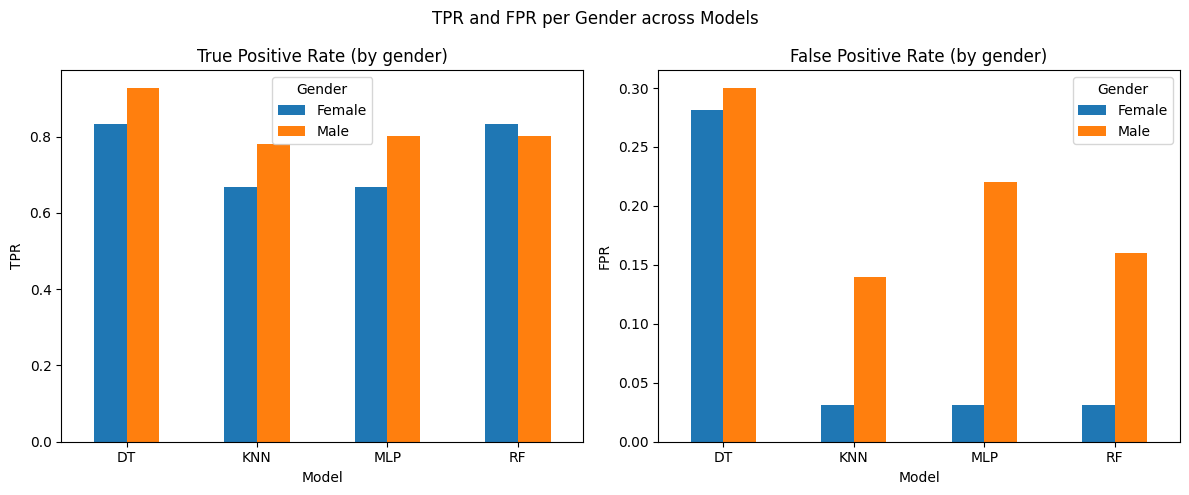

In [29]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## TPR and FPR per Gender Across Models  

### True Positive Rate (TPR)
- **DT**: Higher TPR for males (~0.93) vs females (~0.83).  
- **KNN**: Noticeable gap, males (~0.78) outperform females (~0.67).  
- **MLP**: Similar trend, males (~0.80) > females (~0.67).  
- **RF**: More balanced (~0.83 female vs ~0.80 male).  

### False Positive Rate (FPR)
- **DT**: High FPR for both, slightly higher for males (~0.30) vs females (~0.28).  
- **KNN**: Very low for females (~0.03), but much higher for males (~0.14).  
- **MLP**: Low for females (~0.03), but clearly higher for males (~0.22).  
- **RF**: Similar pattern, females (~0.03) vs males (~0.16).  

### Key Insights  
- **Males generally achieve higher TPRs** across DT, KNN, and MLP, while RF is the most balanced.  
- **FPR disparities are striking**: males incur much higher false positives in KNN, MLP, and RF, while DT shows high FPR for both genders.  
- Overall, **RF provides the best balance**, while **MLP and KNN show large gender gaps** in both TPR and FPR.  

---

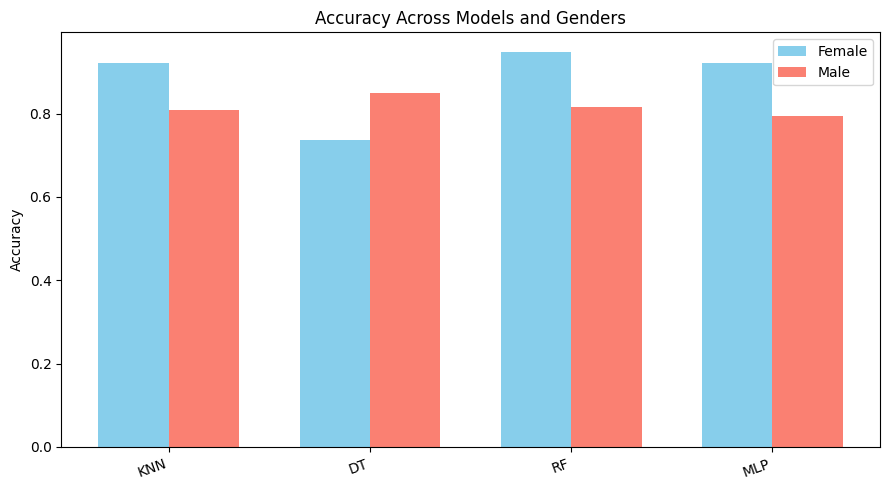

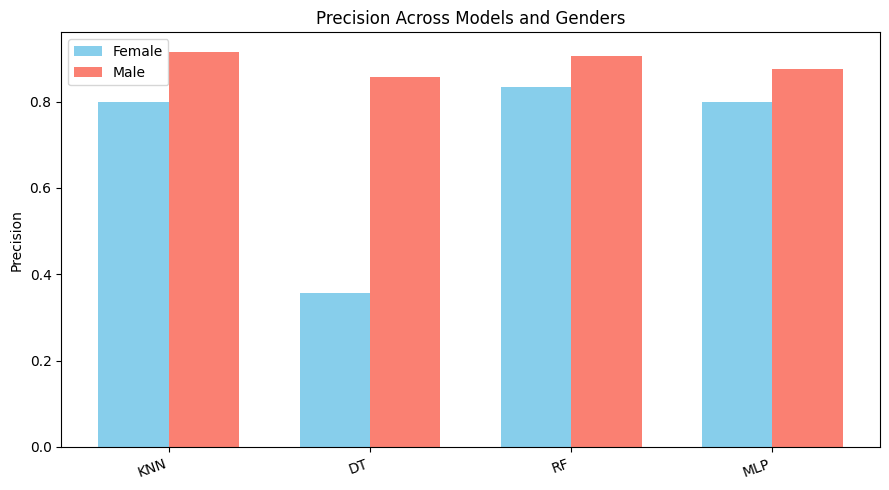

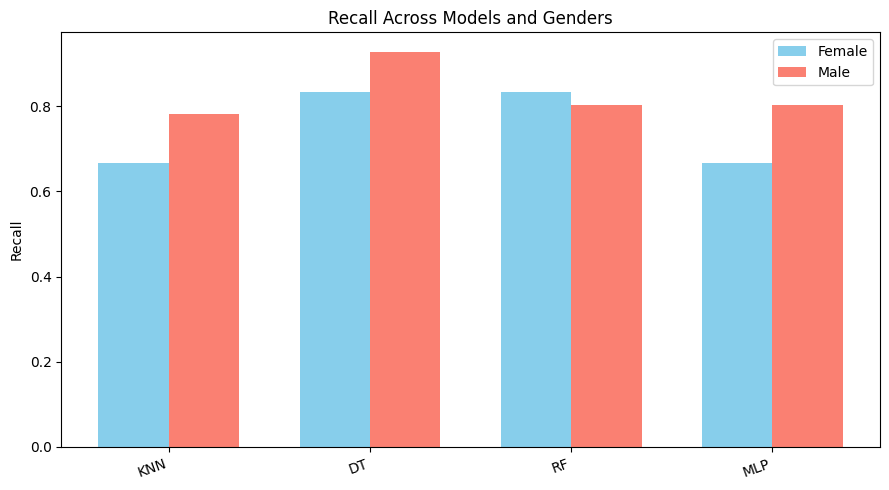

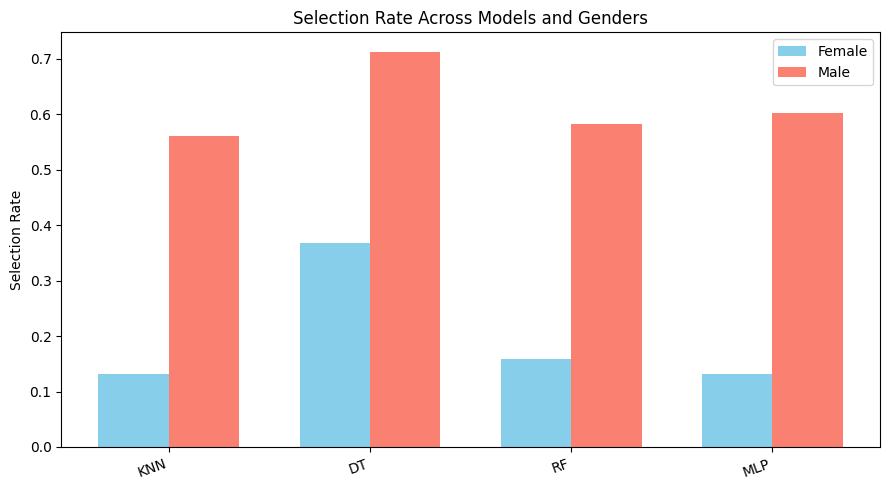

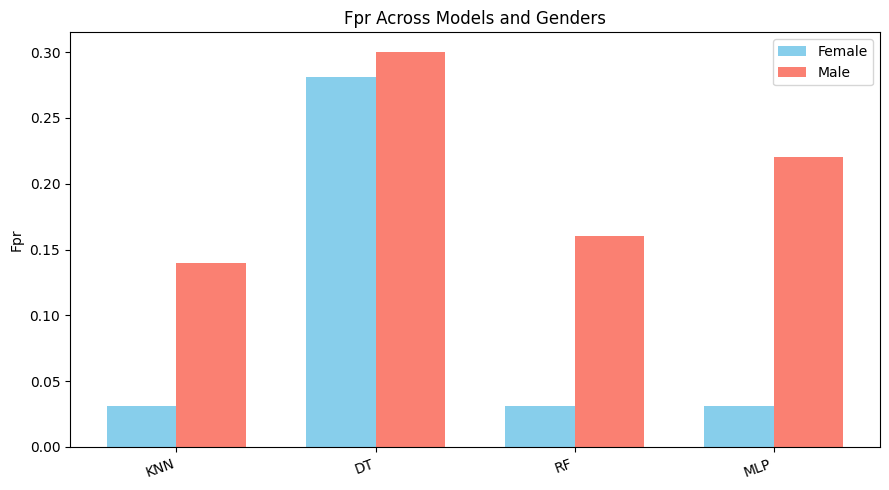

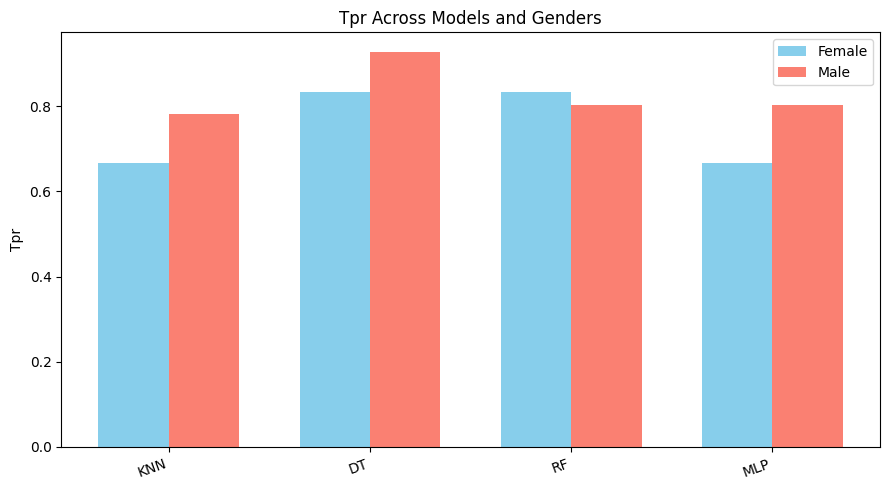

In [30]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Fairness Evaluation Across Models and Genders

The plots compare **accuracy, precision, recall, selection rate, FPR, and TPR** across gender groups for all four models (KNN, DT, RF, MLP).

### Accuracy
- **Females generally achieved higher accuracy** in KNN, RF, and MLP.
- For DT, **males slightly outperformed females**.

### Precision
- Precision was **consistently higher for males** across all models, with the largest gap in **DT**, where female precision is notably low.

### Recall
- **Males had higher recall** across most models, especially in DT and MLP.
- RF was more balanced, though slightly better for females.

### Selection Rate
- Strong disparities are visible:  
  - **Males have much higher selection rates** in all models.  
  - The gap is especially large in **DT and MLP**, suggesting higher positive predictions for men.

### False Positive Rate (FPR)
- **Males exhibit higher FPRs** in all models except KNN, where female FPR is lower.
- DT shows the **highest male FPR**, reflecting more false alarms.

### True Positive Rate (TPR)
- **Males achieve higher TPRs** in all models except RF (where females are slightly ahead).
- The gap is most pronounced in **DT**, highlighting stronger male advantage.

---

### Key Takeaway
While models like RF are relatively more balanced, **KNN, DT, and MLP show systematic male advantages** in precision, recall, and selection rate. The disparities suggest that these models may **underpredict positive outcomes for females**, raising fairness concerns.

---